In [1]:
import pandas as pd
import numpy as np
import zipfile
from tqdm.notebook import tqdm
import tensorflow as tf
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Functions for Cleaning Texts

In [3]:
def deEmojify(text):
  regrex_pattern = re.compile(pattern = "["
      u"\U0001F600-\U0001F64F"  # emoticons
      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
      u"\U0001F680-\U0001F6FF"  # transport & map symbols
      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          "]+", flags = re.UNICODE)
  return regrex_pattern.sub(r'',text)

def preprocess_text(text, english_letters_list, persian_stop_words_list):
  
  # remove punctuations from string(!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~)
  text = text.translate(str.maketrans('', '', string.punctuation))

  # remove all English letters and all digits from string
  text = ''.join(char for char in text if (char not in english_letters_list and not char.isdigit()))

  # removing all emogies from string
  text = deEmojify(text)
  
  # convert from string to list
  lst_text = text.split()

  # remove Persian stopwords
  if persian_stop_words_list is not None:
    lst_text = [word for word in lst_text if word not in persian_stop_words_list]
  text = " ".join(lst_text)

  return text 

In [4]:
train_data = pd.read_csv("/content/drive/MyDrive/SummerCampContest/Question2/train_set.csv", encoding='utf-8')
test_data = pd.read_csv("/content/drive/MyDrive/SummerCampContest/Question2/test_set.csv", encoding='utf-8')

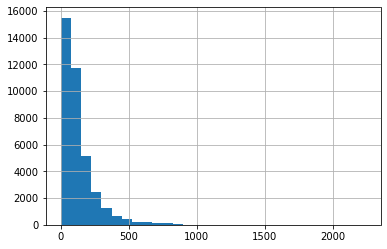

In [5]:
seq_len = [len(i.split()) for i in train_data["description_fa"]]
pd.Series(seq_len).hist(bins = 30)

### Cleaning Dataset

In [7]:
# list of persian stop words
persian_stop_words = pd.read_csv("/content/persian_stop_words.txt")
persian_stop_words_list = persian_stop_words["کلمات ایستای فارسی"].tolist()
# list of all English letters
english_letters_list = list(string.ascii_letters)

In [8]:
train_data["description_fa_clean"] = train_data["description_fa"].apply(lambda x: 
  preprocess_text(x, english_letters_list, persian_stop_words_list))

test_data["description_fa_clean"] = test_data["description_fa"].apply(lambda x: 
  preprocess_text(x, english_letters_list, persian_stop_words_list))

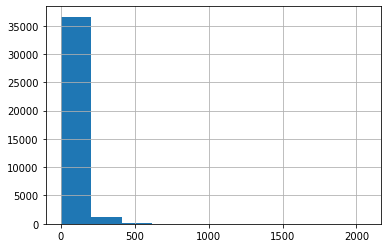

In [9]:
seq_len = [len(i.split()) for i in train_data["description_fa_clean"]]
pd.Series(seq_len).hist(bins = 10)

In [10]:
x_train = train_data["description_fa_clean"].values.tolist()
y_train = train_data["label"].values.tolist()

x_test = test_data["description_fa_clean"].values.tolist()

In [11]:
# split train dataset into train, validation and test sets
# train_text, val_text, train_labels, val_labels = train_test_split(train_data['description_fa_clean'], train_data['label'], 
#                                                                     random_state=2018, 
#                                                                     test_size=0.2, 
#                                                                     stratify=train_data['label'])


## Tokenize Texts

In [ ]:
!pip install transformers

In [13]:
import transformers
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoConfig, AutoTokenizer, TFAutoModel, AutoModel
config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model = TFAutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", num_labels=10)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification

In [15]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    x_train,
    max_length = 250,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
# tokens_val = tokenizer.batch_encode_plus(
#     val_text.tolist(),
#     max_length = 180,
#     pad_to_max_length=True,
#     truncation=True
# )

# tokenize and encode sequences in the validation set
tokens_test = tokenizer.batch_encode_plus(
    x_test,
    max_length = 250,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [16]:
all_train_input_ids = []
all_train_attention_masks = []
all_train_token_type_ids = []
all_train_labels = []

for i in range(len(tokens_train["input_ids"])):
  all_train_input_ids.append(tf.constant(tokens_train["input_ids"][i]))
  all_train_attention_masks.append(tf.constant(tokens_train["attention_mask"][i]))
  all_train_token_type_ids.append(tf.constant(tokens_train["token_type_ids"][i]))
  all_train_labels.append(tf.constant(y_train[i]))

In [17]:
# xdata = [np.array(all_input_ids), np.array(all_attention_masks), np.array(all_token_type_ids)]
# ydata = all_labels
# train_dataset_base = [xdata, ydata]

train_dataset_base = tf.data.Dataset.from_tensor_slices(({
            'input_ids': all_train_input_ids,
            'attention_mask': all_train_attention_masks,
            'token_type_ids': all_train_token_type_ids
        }, all_train_labels))

In [ ]:
# all_val_input_ids = []
# all_val_attention_masks = []
# all_val_token_type_ids = []
# all_val_labels = []

# for i in range(len(tokens_val["input_ids"])):
#   all_val_input_ids.append(tf.constant(tokens_val["input_ids"][i]))
#   all_val_attention_masks.append(tf.constant(tokens_val["attention_mask"][i]))
#   all_val_token_type_ids.append(tf.constant(tokens_val["token_type_ids"][i]))
#   all_val_labels.append(tf.constant(val_labels.tolist()[i]))

In [ ]:
# x_val_data = [np.array(all_val_input_ids), np.array(all_val_attention_masks), np.array(all_val_token_type_ids)]
# y_val_data = all_labels
# val_dataset_base = [x_val_data, y_val_data]

# val_dataset_base = tf.data.Dataset.from_tensor_slices(({
#             'input_ids': all_val_input_ids,
#             'attention_mask': all_val_attention_masks,
#             'token_type_ids': all_val_token_type_ids
#         }, all_val_labels))

In [18]:
all_test_input_ids = []
all_test_attention_masks = []
all_test_token_type_ids = []

for i in range(len(tokens_test["input_ids"])):
  all_test_input_ids.append(tf.constant(tokens_test["input_ids"][i]))
  all_test_attention_masks.append(tf.constant(tokens_test["attention_mask"][i]))
  all_test_token_type_ids.append(tf.constant(tokens_test["token_type_ids"][i]))

In [19]:
# test_dataset_base = tf.data.Dataset.from_tensor_slices(({
#             'input_ids': all_test_input_ids,
#             'attention_mask': all_test_attention_masks,
#             'token_type_ids': all_test_token_type_ids
#         }))
xtest = [np.array(all_test_input_ids), np.array(all_test_attention_masks), np.array(all_test_token_type_ids)]

In [20]:
for value in train_dataset_base.take(1):
  print(f'     input_ids: {value[0]["input_ids"]}')
  print(f'attention_mask: {value[0]["attention_mask"]}')
  print(f'token_type_ids: {value[0]["token_type_ids"]}')
  print(f'        target: {value[1]}')

     input_ids: [    2  2340  3888  2385  6050  3888  3178  4203  2340  4628  4879  2385
  3143  7320  9675  2872  4479  2340 14706  2801  2964  2340  3361  5170
  2340 17498   300  3931  2806  4360  2340  5170  4037  2340  2384  2385
  2340  7534  5802 29132     4     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     

In [21]:
def get_training_dataset(dataset, batch_size):
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)

    return dataset

def get_validation_dataset(dataset, batch_size):
    dataset = dataset.batch(batch_size)

    return dataset

In [23]:
TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 8

train_dataset = get_training_dataset(train_dataset_base, TRAIN_BATCH_SIZE)
# valid_dataset = get_training_dataset(val_dataset_base, VALID_BATCH_SIZE)

train_steps = len(tokens_train["input_ids"]) // TRAIN_BATCH_SIZE
# valid_steps = len(tokens_val["input_ids"]) // VALID_BATCH_SIZE

train_steps

1184

## Model

In [24]:
def build_model(model_name, config, learning_rate=3e-5):
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=10)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    return model

In [25]:
model = build_model("HooshvareLab/bert-base-parsbert-uncased", config, learning_rate=3e-5)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Fine-Tune BERT

In [26]:
%%time
EPOCHS = 10
r = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    verbose=1)

# save the model
import os
model.save_pretrained(os.path.dirname("/content/drive/MyDrive/SummerCampContest/Question1/"))

# final_accuracy = r.history['val_accuracy']

# print('FINAL ACCURACY MEAN: ', np.mean(final_accuracy))

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autog

KeyError: ignored

In [27]:
# save the model
import os
model.save_pretrained(os.path.dirname("/content/drive/MyDrive/SummerCampContest/Question2/"))

### Evaluation / Prediction

In [28]:
# ev = model.evaluate(test_dataset_base.batch(TEST_BATCH_SIZE))
# print()
# print(f'Evaluation: {ev}')
# print()

predictions = model.predict(xtest)
ypred = predictions[0].argmax(axis=-1).tolist()

# print()
# print(classification_report(ytest, ypred, target_names=labels))
# print()

# print(f'F1: {f1_score(ytest, ypred, average="weighted")}')

In [29]:
test_data["label"] = ypred

In [30]:
prediction = test_data.drop(['description_fa', 'description_fa_clean'], axis=1)

In [31]:
prediction.to_csv("/content/drive/MyDrive/SummerCampContest/Question2/prediction_250_all_data.csv", index=False) 

In [32]:
len(predictions[0])

10000

In [ ]:
test_data

,app_id,description_fa,description_fa_clean,label
0,40000,<h4>در این برنامه یکی از بازی های جالب میکرو ر...,برنامه بازی جالب میکرو آماده بازی جنگ بالون با...,6
1,40001,<p>بازی آموزشی میلونر زبان انگلیسی برای تقویت ...,بازی آموزشی میلونر زبان انگلیسی تقویت زبان انگ...,5
2,40002,<p> <b>موضوع رو می بینی و کلمات رو پیدا می کنی...,موضوع بینی کلمات شاد سرگرم حدس کلمات موضوع سبک...,5
3,40003,<p>نرم افزار فول تلگرام در کنار تلگرام امكانات...,نرم افزار فول تلگرام تلگرام امكاناتي بهتون نرم...,8
4,40004,<p> فکر می کنی خیلی سریع هستی نه؟ <br> ...,نه؟ تونی امتحان بازی ساده جذاب بازی مانع بپری ...,3
...,...,...,...,...
9995,49995,<p>فالوورگیر اینستاگرام با امکانات <b>لایک </b...,فالوورگیر اینستاگرام امکانات لایک اینستاگرام ک...,9
9996,49996,<p><b>میخوای نامحدود آنفلو کنی ؟</b></p>\n<p><...,میخوای نامحدود آنفلو ؟ دلتون خواد عكس‌های اینس...,9
9997,49997,<p>یک بازی زیبا از کنسول میکرو</p>\n<p>به یاد ...,بازی زیبا کنسول میکرو یاد براتون بازیه زیبا فک...,6
9998,49998,<p>دوست داری اطلاعات عمومی بالایی داشته باشی؟&...,دوست اطلاعات عمومی بالایی باشی؟ دوست جهان اطرا...,5


In [ ]:
prediction

,app_id,label
0,40000,6
1,40001,5
2,40002,5
3,40003,8
4,40004,3
...,...,...
9995,49995,9
9996,49996,9
9997,49997,6
9998,49998,5
